## Image search Using CLIP models

We use the Flickr 8k image captioning datasets, for which you can find examples at [this link](https://hockenmaier.cs.illinois.edu/8k-pictures.html). The data can be downloaded from [Kaggle Flickr8k-Images-Captions](https://www.kaggle.com/datasets/aladdinpersson/flickr8kimagescaptions/data)

[CLIP](https://openai.com/index/clip/) is a pretrained image+text model by OpenAI. The pretained CLIP model support the image search out-of-box.

In [1]:
# !pip install pip install transformers torchvision faiss-cpu

In [12]:
import torchvision
import torch
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import numpy as np

## Utility Functions

In [3]:

image_dir='data/flickr8k/images'
caption_path='data/flickr8k/captions.txt'

caption_df = pd.read_csv(caption_path)

def load_examples(start, end):
    imgs = []
    texts = []
    for i, row in caption_df.iloc[start:end,:].iterrows():
        img_path = os.path.join(image_dir, row['image'])
        img = Image.open(img_path)
        imgs.append(img)
        texts.append(row['caption'])

    return imgs, texts


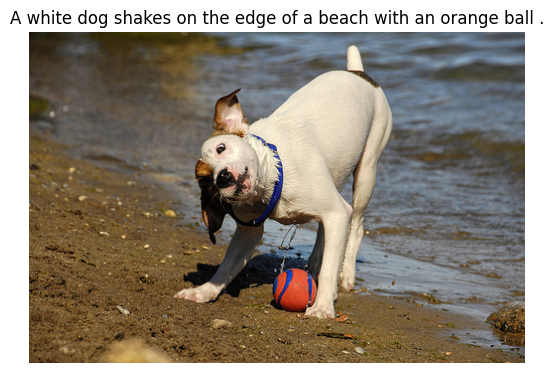

In [6]:
# display a random pic
import random

def show_pic(index):
    row = caption_df.iloc[index, :]

    img_path = os.path.join(image_dir, row['image'])
    img = Image.open(img_path)

    plt.title(row['caption'])
    plt.axis("off")
    plt.imshow(img)
    
rand_index = random.randint(0, 100)
show_pic(rand_index)

In [7]:
# display the dot product of two embedding matrics

def show_dot_similarity(emb_1, emb_2):
    dot_sim = np.dot(emb_1, emb_2.T)
    plt.imshow(dot_sim)
    plt.show()

## Load CLIP model

In [8]:
from transformers import CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)


/Users/santan/workspace/torchspace/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [9]:
def create_img_emb_batch(img_batch):
    images = processor(text=None, images=img_batch, return_tensors='pt')['pixel_values']
    img_emb = model.get_image_features(images)
    img_emb = img_emb.detach()
    norm_img_emb = torch.nn.functional.normalize(img_emb, p=2, dim=1)
    return norm_img_emb.numpy()

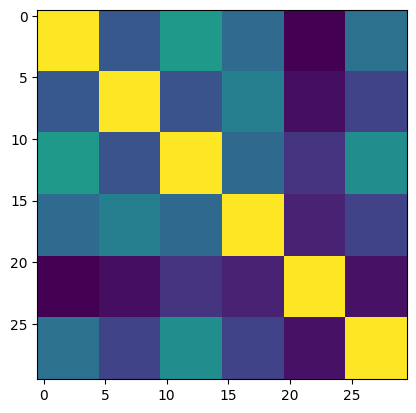

In [13]:
# Let load 30 pics and build embeddings, and make sure that embeddings are sensible

imgs_30, texts_30 = load_examples(0, 30)

img_30_embeddings = create_img_emb_batch(imgs_30)

show_dot_similarity(img_30_embeddings, img_30_embeddings)

In [14]:
def encode_text(text):
    tokens = processor(text=text, padding=True, images=None, return_tensors='pt')
    text_emb = model.get_text_features(**tokens)
    text_emb = text_emb.detach()
    # print(f'text_emb: {text_emb.size()}')
    norm_text_emb = torch.nn.functional.normalize(text_emb, p=2, dim=1)
    return norm_text_emb.numpy()

# encode_text('a little girl')

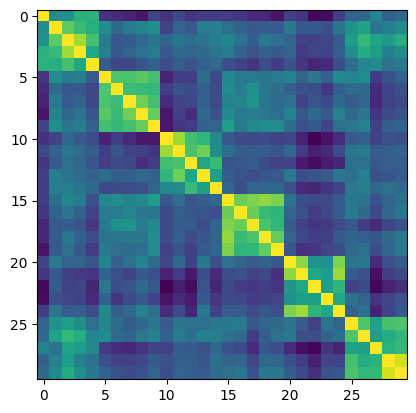

In [15]:
# Check whether the text embeddings are sensible

text_30_embeddings = encode_text(texts_30)

show_dot_similarity(text_30_embeddings, text_30_embeddings)

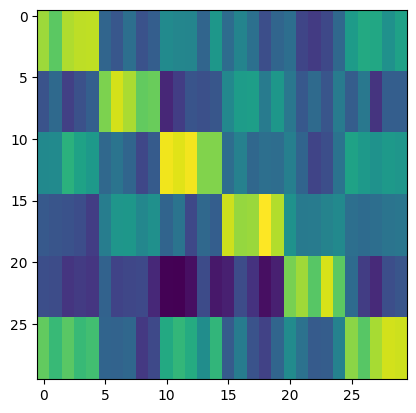

In [16]:

# check whether the image embeddings are correlated with the text embeddings nicely

show_dot_similarity(img_30_embeddings, text_30_embeddings)

## Load FAISS and add image embeddings

In [17]:
import faiss

d = 512
# Be simple and use flat/no search index
index = faiss.IndexFlatIP(d)

In [18]:
%%time

# this cell will create a spike of memory usage

loaded_records = 1000

imgs_1000, texts_1000 = load_examples(0, loaded_records)

img_1000_embeddings = create_img_emb_batch(imgs_1000)

index.add(img_1000_embeddings)

CPU times: user 40.7 s, sys: 52.2 s, total: 1min 32s
Wall time: 17.6 s


search text: (text)
the matched indice: I: [[3 2 1 0]]


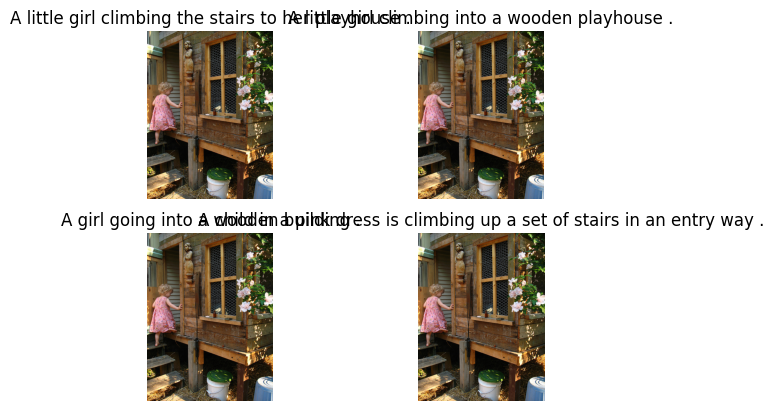

In [24]:
# test searching using example caption

def search_n_show(text):
    text_emb = encode_text(text)
    print(f'search text: (text)')
    
    num_nb = 4
    D, I = index.search(text_emb, num_nb)
    print(f'the matched indice: I: {I}')
    
    figure = plt.figure()
    for i, img_index in enumerate(I[0]):
        figure.add_subplot(2, 2, i + 1)
        show_pic(img_index)

search_n_show(texts_1000[0])

## Real Search examples

search text: (text)
the matched indice: I: [[778 777 776 775]]


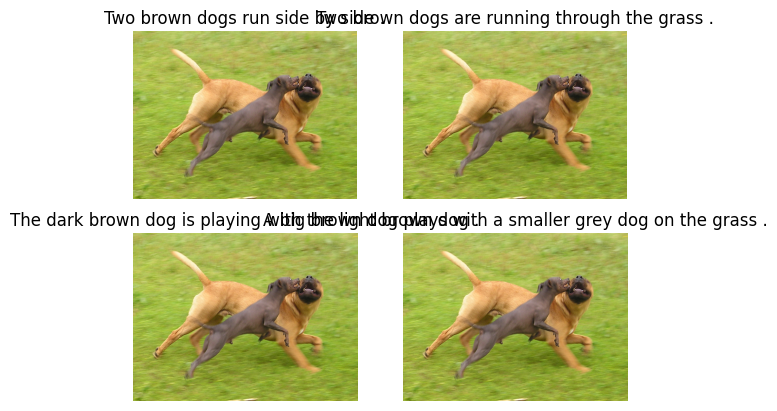

In [26]:
search_n_show('dog fight')